# Auto Incoder

# 기본 오토 인코더 활용 노이즈 제거

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.2884 - val_loss: 0.1151
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.1487 - val_loss: 0.0730
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0909 - val_loss: 0.0700
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0788 - val_loss: 0.0705
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0789 - val_loss: 0.0711
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0804 - val_loss: 0.0714
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0807 - val_loss: 0.0714
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0809 - val_loss: 0.0711
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0819 - val_loss: 0.0707
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0808 - val_loss: 0.0700
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0798 - val_loss: 0.0693
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0798 - val_loss: 0.0685
Epoch 13/20
2/2 ━━━━━━━━━

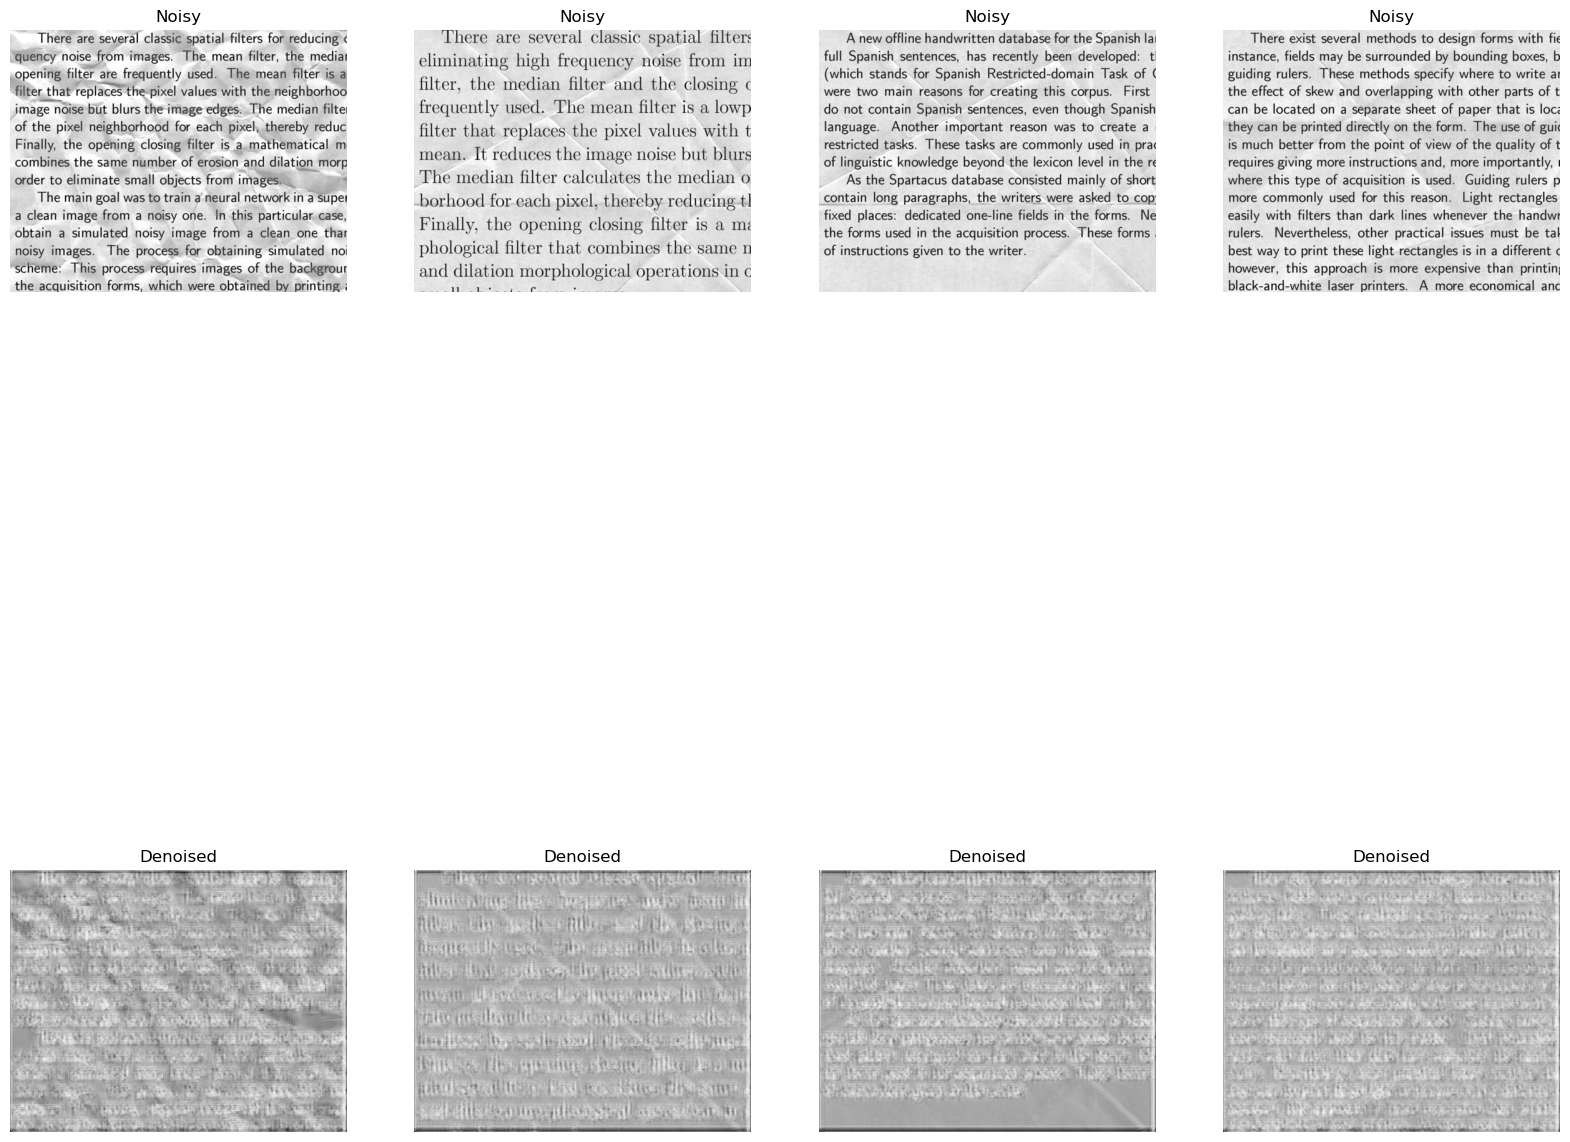

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt

# 노이즈가 있는 이미지와 깨끗한 이미지 경로 설정
noisy_imgs_path = 'noisy/'
clean_imgs_path = 'clean/'

X_train_noisy = []
X_train_clean = []

# 이미지 파일 로드 및 전처리
for file in sorted(os.listdir(clean_imgs_path)):
    img = load_img(clean_imgs_path + file, color_mode='grayscale', target_size=(420, 540))
    img = img_to_array(img).astype('float32') / 255.
    X_train_clean.append(img)

# 파일 목록 가져와서 알파벳 순서로 정렬
for file in sorted(os.listdir(noisy_imgs_path)):            
    # 이미지 로드, 흑백으로 색상 변환
    img = load_img(noisy_imgs_path + file, color_mode='grayscale', target_size=(420, 540))
    # 이미지 정규화(0~1사이의 값으로 변환)
    img = img_to_array(img).astype('float32') / 255.         
    X_train_noisy.append(img)


# 넘파이 배열로 변환
X_train_noisy = np.array(X_train_noisy)
X_train_clean = np.array(X_train_clean)

# 노이즈 이미지 첫 20개를 테스트 이미지로 사용
X_test_noisy = X_train_noisy[0:20,]
X_train_noisy = X_train_noisy[20:,]

# 정상 이미지 첫 20개를 테스트 이미지로 사용
X_test_clean = X_train_clean[0:20,]
X_train_clean = X_train_clean[20:,]

# 오토 인코더 모델 구성
def build_autoenocder():
    input_img = Input(shape=(420, 540, 1), name='image_input')
    
    #### enoder
    x = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    #### decoder
    x = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', kernel_initializer='he_normal', padding='same')(x)

    # model
    autoencoder = Model(inputs=input_img, outputs=x)

    return autoencoder
# 예측 결과 시각화
model = build_autoenocder()
model.compile(optimizer=Adam(), loss='MSE') #
hint = model.fit(X_train_noisy, X_train_clean, epochs=20, batch_size=32, validation_split=0.2)
output = model.predict(X_test_noisy)

n = 4  # 첫 10개 이미지를 비교
plt.figure(figsize=(20, 20))
for i in range(n):
    # 노이즈 이미지 표시
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_noisy[i].reshape(420, 540), cmap='gray')
    plt.title("Noisy")
    plt.axis("off")

    # 예측한 이미지 표시
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output[i].reshape(420, 540), cmap='gray')
    plt.title("Denoised")
    plt.axis("off")

plt.show()


### 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


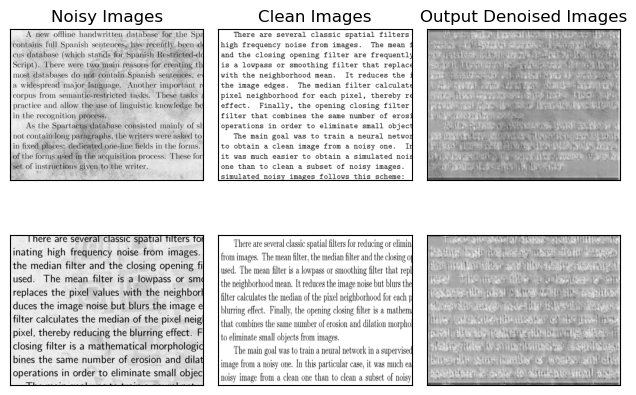

In [17]:
# 결과 출력
import random
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

randomly_selected_imgs = random.sample(range(X_test_noisy.shape[0]),2)
X_pred = model.predict(X_test_noisy)
for i, ax in enumerate([ax1, ax4]):
  idx = randomly_selected_imgs[i]
  ax.imshow(X_test_noisy[idx].reshape(420,540), cmap='gray')
  if i == 0:
      ax.set_title("Noisy Images")
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

for i, ax in enumerate([ax2, ax5]):
  idx = randomly_selected_imgs[i]
  ax.imshow(X_test_clean[idx].reshape(420,540), cmap='gray')
  if i == 0:
      ax.set_title("Clean Images")
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

for i, ax in enumerate([ax3, ax6]):
  idx = randomly_selected_imgs[i]
  ax.imshow(output[idx].reshape(420,540), cmap='gray')
  if i == 0:
      ax.set_title("Output Denoised Images")
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

# CNN 활용 노이즈 제거(1 레이어)

In [ ]:
import matplotlib
matplotlib.use("TkAgg")
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from matplotlib import pyplot as plt
import numpy as np
import os
import random
from keras.preprocessing.image import load_img, img_to_array


# Import noisy office documents dataset
noisy_imgs_path = 'Noisy_Documents/noisy/'
clean_imgs_path = 'Noisy_Documents/clean/'

X_train_noisy = []
X_train_clean = []

for file in sorted(os.listdir(noisy_imgs_path)):
  img = load_img(noisy_imgs_path+file, color_mode='grayscale', target_size=(420,540))
  img = img_to_array(img).astype('float32')/255
  X_train_noisy.append(img)

for file in sorted(os.listdir(clean_imgs_path)):
  img = load_img(clean_imgs_path+file, color_mode='grayscale', target_size=(420,540))
  img = img_to_array(img).astype('float32')/255
  X_train_clean.append(img) 

# 넘파이 배열로 변환
X_train_noisy = np.array(X_train_noisy)
X_train_clean = np.array(X_train_clean)

# 노이즈 이미지 첫 20개를 테스트 이미지로 사용
X_test_noisy = X_train_noisy[0:20,]
X_train_noisy = X_train_noisy[20:,]

# 정상 이미지 첫 20개를 테스트 이미지로 사용
X_test_clean = X_train_clean[0:20,]
X_train_clean = X_train_clean[20:,]


# 모델 레이어 구성


# 컴파일


# 훈련


# 예측
output = 

### 시각화

In [ ]:
# 결과 출력
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

randomly_selected_imgs = random.sample(range(X_test_noisy.shape[0]),2)

for i, ax in enumerate([ax1, ax4]):
  idx = randomly_selected_imgs[i]
  ax.imshow(X_test_noisy[idx].reshape(420,540), cmap='gray')
  if i == 0:
      ax.set_title("Noisy Images")
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

for i, ax in enumerate([ax2, ax5]):
  idx = randomly_selected_imgs[i]
  ax.imshow(X_test_clean[idx].reshape(420,540), cmap='gray')
  if i == 0:
      ax.set_title("Clean Images")
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

for i, ax in enumerate([ax3, ax6]):
  idx = randomly_selected_imgs[i]
  ax.imshow(output[idx].reshape(420,540), cmap='gray')
  if i == 0:
      ax.set_title("Output Denoised Images")
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

# CNN 활용 노이즈 제거(다층 레이어)

In [ ]:
import matplotlib
matplotlib.use("TkAgg")
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from matplotlib import pyplot as plt
import numpy as np
import os
import random
from keras.preprocessing.image import load_img, img_to_array

# Import noisy office documents dataset
noisy_imgs_path = 'Noisy_Documents/noisy/'
clean_imgs_path = 'Noisy_Documents/clean/'

X_train_noisy = []
X_train_clean = []

for file in sorted(os.listdir(noisy_imgs_path)):
    img = load_img(noisy_imgs_path+file, color_mode='grayscale', target_size=(420,540))
    img = img_to_array(img).astype('float32')/255
    X_train_noisy.append(img)

for file in sorted(os.listdir(clean_imgs_path)):
    img = load_img(clean_imgs_path+file, color_mode='grayscale', target_size=(420,540))
    img = img_to_array(img).astype('float32')/255
    X_train_clean.append(img)

# 넘파이 배열로 변환
X_train_noisy = np.array(X_train_noisy)
X_train_clean = np.array(X_train_clean)

# 노이즈 이미지 첫 20개를 테스트 이미지로 사용
X_test_noisy = X_train_noisy[0:20,]
X_train_noisy = X_train_noisy[20:,]

# 정상 이미지 첫 20개를 테스트 이미지로 사용
X_test_clean = X_train_clean[0:20,]
X_train_clean = X_train_clean[20:,]


# 모델 레이어 구성


# 컴파일


# 훈련


# 예측
output = 

### 시각화

In [ ]:
# 결과 출력
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

randomly_selected_imgs = random.sample(range(X_test_noisy.shape[0]),2)

for i, ax in enumerate([ax1, ax4]):
    idx = randomly_selected_imgs[i]
    ax.imshow(X_test_noisy[idx].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Noisy Images")
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, ax in enumerate([ax2, ax5]):
    idx = randomly_selected_imgs[i]
    ax.imshow(X_test_clean[idx].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Clean Images")
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

for i, ax in enumerate([ax3, ax6]):
    idx = randomly_selected_imgs[i]
    ax.imshow(output[idx].reshape(420,540), cmap='gray')
    if i == 0:
        ax.set_title("Output Denoised Images")
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
